# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Table of Contents

The different points that will be followed in this notebook to predict churn are enumerated here

##  I. [Import libraries and Spark session](#Import-libraries-and-Spark-session)


## II. [Load and Clean Dataset](#Load-and-Clean-Dataset)
- [Load the data](#Load-the-data)<br>
- [General overview of the data](#General-overview-of-the-data)<br>
- [Clean Data](#Clean-Data)<br>

## III. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Define Churn](#Define-Churn)<br>
- [Explore Data](#Explore-Data)<br>

## IV. [Feature Engineering](#Feature-Engineering)

## V. [Modeling](#Modeling)
- [Data preparation](#Data-preparation)<br>
- [Machine Learning models](#Machine-Learning-models)<br>
- [Results](#Results)<br>

## VI. [Summary](#Summary)

# <a class="anchor" id="Import-libraries-and-Spark-session">I. Import libraries and Spark session</a>

In [351]:
# import libraries
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#! pip install pyspark
import pyspark
from pyspark import SparkContext, SparkConf

from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when, desc, asc, countDistinct, when, isnan
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround
from pyspark.sql.types import IntegerType, FloatType, DateType, TimestampType, StringType

from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

%matplotlib inline

In [352]:
# Create a Spark session
spark = SparkSession \
        .builder \
        .appName("Sparkify") \
        .getOrCreate()

# <a class="anchor" id="Load-and-Clean-Dataset">II. Load and Clean Dataset</a>
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

### <a class="anchor" id="Load-the-data">Load the data</a>

In [379]:
path = "mini_sparkify_event_data.json"
sparkify_events = spark.read.json(path)

### <a class="anchor" id="General-overview-of-the-data">General overview of the data</a>

In [354]:
sparkify_events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [355]:
print("The number of rows is", sparkify_events.count())
print("The number of columns is", len(sparkify_events.columns))

The number of rows is 286500
The number of columns is 18


In [356]:
# Check the unique values of some categories to have an idea of the data
for col in ['auth', 'gender', 'location', 'level', 'method', 'page', 'status', 'registration']:
    print(sparkify_events.groupby(col).count().show(30))

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+

None
+------+------+
|gender| count|
+------+------+
|     F|154578|
|  null|  8346|
|     M|123576|
+------+------+

None
+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|San Diego-Carlsba...|  754|
|Cleveland-Elyria, OH| 1392|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
|Allentown-Bethleh...|  815|
|Miami-Fort Lauder..

In [357]:
# Print first 2 lines of 'sparkify_events'
sparkify_events.show(n=2, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------
 artist        | Martha Tilston                                                                                                  
 auth          | Logged In                                                                                                       
 firstName     | Colin                                                                                                           
 gender        | M                                                                                                               
 itemInSession | 50                                                                                                              
 lastName      | Freeman                                                                                                         
 length        | 277.89016                                                                

### <a class="anchor" id="Clean-Data">Clean Data</a>

#### Missing values

In [358]:
# Check columns with NaN values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of missing values is", sparkify_events.where(sparkify_events[value].isNull()).count())

In column ( artist ) the number of missing values is 58392
In column ( auth ) the number of missing values is 0
In column ( firstName ) the number of missing values is 8346
In column ( gender ) the number of missing values is 8346
In column ( itemInSession ) the number of missing values is 0
In column ( lastName ) the number of missing values is 8346
In column ( length ) the number of missing values is 58392
In column ( level ) the number of missing values is 0
In column ( location ) the number of missing values is 8346
In column ( method ) the number of missing values is 0
In column ( page ) the number of missing values is 0
In column ( registration ) the number of missing values is 8346
In column ( sessionId ) the number of missing values is 0
In column ( song ) the number of missing values is 58392
In column ( status ) the number of missing values is 0
In column ( ts ) the number of missing values is 0
In column ( userAgent ) the number of missing values is 8346
In column ( userId )

#### Empty values

In [359]:
# Check columns with empty values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of empty values is", sparkify_events.filter(sparkify_events[value] == '').count())

In column ( artist ) the number of empty values is 0
In column ( auth ) the number of empty values is 0
In column ( firstName ) the number of empty values is 0
In column ( gender ) the number of empty values is 0
In column ( itemInSession ) the number of empty values is 0
In column ( lastName ) the number of empty values is 0
In column ( length ) the number of empty values is 0
In column ( level ) the number of empty values is 0
In column ( location ) the number of empty values is 0
In column ( method ) the number of empty values is 0
In column ( page ) the number of empty values is 0
In column ( registration ) the number of empty values is 0
In column ( sessionId ) the number of empty values is 0
In column ( song ) the number of empty values is 0
In column ( status ) the number of empty values is 0
In column ( ts ) the number of empty values is 0
In column ( userAgent ) the number of empty values is 0
In column ( userId ) the number of empty values is 8346


In [360]:
# Delete columns with empty userid
sparkify_events = sparkify_events.filter(sparkify_events.userId != "")

In [361]:
# Check columns with empty values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of empty values is", sparkify_events.filter(sparkify_events[value] == '').count())

In column ( artist ) the number of empty values is 0
In column ( auth ) the number of empty values is 0
In column ( firstName ) the number of empty values is 0
In column ( gender ) the number of empty values is 0
In column ( itemInSession ) the number of empty values is 0
In column ( lastName ) the number of empty values is 0
In column ( length ) the number of empty values is 0
In column ( level ) the number of empty values is 0
In column ( location ) the number of empty values is 0
In column ( method ) the number of empty values is 0
In column ( page ) the number of empty values is 0
In column ( registration ) the number of empty values is 0
In column ( sessionId ) the number of empty values is 0
In column ( song ) the number of empty values is 0
In column ( status ) the number of empty values is 0
In column ( ts ) the number of empty values is 0
In column ( userAgent ) the number of empty values is 0
In column ( userId ) the number of empty values is 0


We got rid of the userId rows that were empty. Now let's take a look at the NaN values

In [362]:
# Check columns with NaN values
for value in sparkify_events.columns:
    print ("In column (",value,") the number of missing values is", sparkify_events.where(sparkify_events[value].isNull()).count())

In column ( artist ) the number of missing values is 50046
In column ( auth ) the number of missing values is 0
In column ( firstName ) the number of missing values is 0
In column ( gender ) the number of missing values is 0
In column ( itemInSession ) the number of missing values is 0
In column ( lastName ) the number of missing values is 0
In column ( length ) the number of missing values is 50046
In column ( level ) the number of missing values is 0
In column ( location ) the number of missing values is 0
In column ( method ) the number of missing values is 0
In column ( page ) the number of missing values is 0
In column ( registration ) the number of missing values is 0
In column ( sessionId ) the number of missing values is 0
In column ( song ) the number of missing values is 50046
In column ( status ) the number of missing values is 0
In column ( ts ) the number of missing values is 0
In column ( userAgent ) the number of missing values is 0
In column ( userId ) the number of mis

# <a class="anchor" id="Exploratory-Data-Analysis">III. Exploratory Data Analysis</a>

When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### <a class="anchor" id="Define-Churn">Define Churn</a>
Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

#### Cancellation Confirmation

In [363]:
# Flag definition for churn (Cancellation Confirmation)
churn_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
sparkify_events = sparkify_events.withColumn("churn", churn_flag("page"))

# Apply churn flag to dataset
window_val = Window.partitionBy("userId")
sparkify_events = sparkify_events.withColumn("churn", Fsum("churn").over(window_val))

In [364]:
# Churned users
sparkify_events["userId", "churn"].dropDuplicates().groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



#### Downgrade Events

In [365]:
# Flag definition for churn (Downgrade)
churn_downgrade = udf(lambda x: 1 if x == "Downgrade" else 0, IntegerType())
sparkify_events = sparkify_events.withColumn("downgrade", churn_downgrade("page"))

# Apply churn flag to dataset
windowval_val = Window.partitionBy("userId")
sparkify_events = sparkify_events.withColumn("downgrade", Fsum("downgrade").over(windowval_val))

In [366]:
# Downgraded users
sparkify_events["userId", "downgrade"].dropDuplicates().groupby("downgrade").count().show()

+---------+-----+
|downgrade|count|
+---------+-----+
|       26|    2|
|       19|    2|
|        0|   71|
|       22|    5|
|        7|    4|
|       50|    1|
|       32|    2|
|       31|    1|
|       39|    1|
|       25|    2|
|        6|    9|
|       68|    1|
|        9|   11|
|       27|    1|
|       17|    2|
|       41|    2|
|       28|    2|
|        5|   12|
|        1|    6|
|       10|    8|
+---------+-----+
only showing top 20 rows



### <a class="anchor" id="Explore-Data">Explore Data</a>

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Churn by gender
We will start taking a look at the churn rate by gender

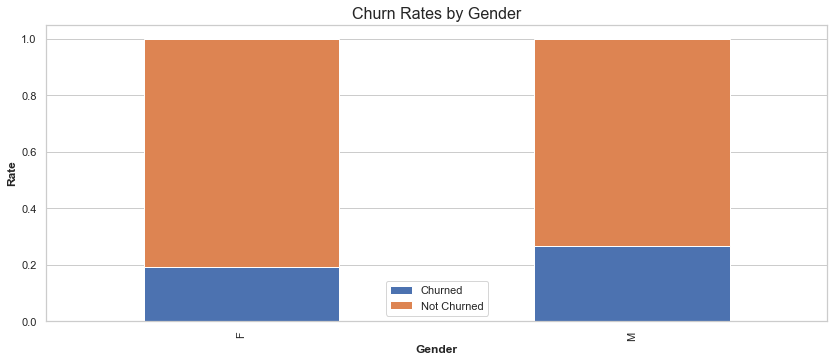

In [367]:
# Churn by Gender
churn_g = sparkify_events.groupby('gender', 'churn').agg(countDistinct('userId')).toPandas().\
          rename(columns = {'count(userId)':'n_users'}).pivot(index = 'gender', columns = 'churn', values = 'n_users').\
          rename(columns = {0:'Not Churned', 1:'Churned'})

churn_g['All']= churn_g['Not Churned'] + churn_g['Churned']
churn_g['Churned'] = churn_g['Churned'] / churn_g['All']
churn_g['Not Churned'] = 1 - churn_g['Churned']

fig = plt.figure(figsize = (14, 12))
ax1 = fig.add_subplot(2,1,2)
churn_g[['Churned','Not Churned']].plot(kind = 'bar', ax = ax1, stacked = True)
plt.title('Churn Rates by Gender', fontsize=16)
plt.ylabel("Rate", fontsize=12, fontweight='bold')
plt.xlabel("Gender", fontsize=12, fontweight='bold')
plt.legend(loc = 'best')
plt.grid(axis='x')

It seems that Male users have a slightly more tendency to cancel their subscription

#### Page events
Now we will take a look at the number of "page" events registered in the dataset

Text(0.5, 0, 'Number of interactions')

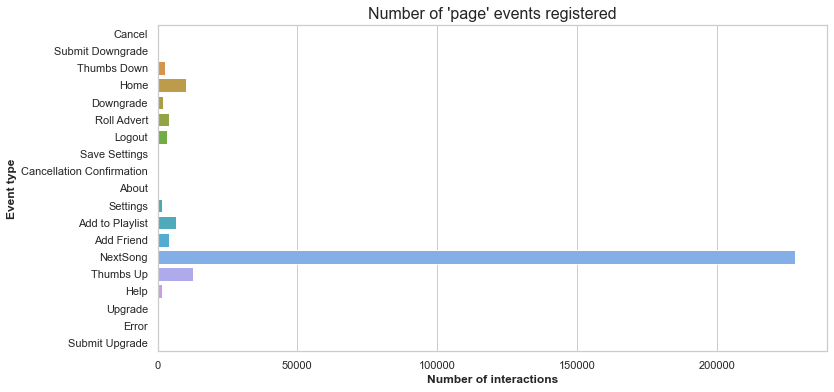

In [368]:
# Number of "page" events registered
data = sparkify_events.groupby("page").count().alias("count").toPandas()
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x="count", y="page", data=data)
ax.set_title("Number of 'page' events registered", fontsize=16)
ax.set_ylabel("Event type", fontsize=12, weight='bold')
ax.set_xlabel("Number of interactions", fontsize=12, weight='bold')

Text(0.5, 0, 'Number of interactions')

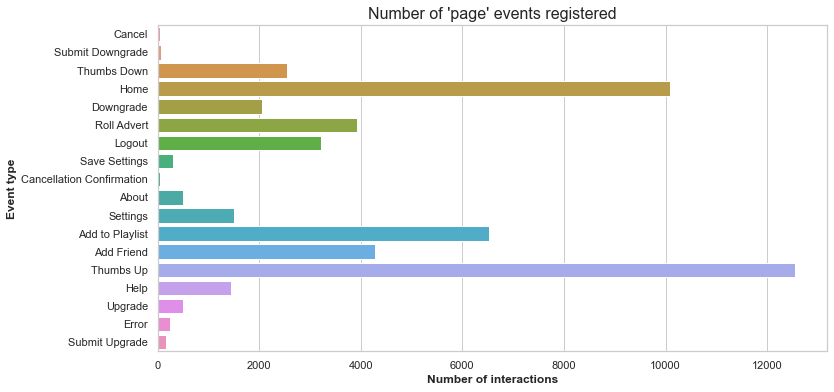

In [369]:
# Number of "page" events registered without 'NextSong'
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x="count", y="page", data=data[data.page!='NextSong'])
ax.set_title("Number of 'page' events registered", fontsize=16)
ax.set_ylabel("Event type", fontsize=12, weight='bold')
ax.set_xlabel("Number of interactions", fontsize=12, weight='bold')

As expected in a music service, "NextSong" event is the one with the most interactions

#### Days passed until Cancellation Confirmation
Let's calculate the days that users take to submit a Cancellation Confirmation event

In [370]:
# Filter to users that have confirmed the cancellation
cancel_sparkify_date = sparkify_events[sparkify_events['page'] == 'Cancellation Confirmation'].toPandas()

# Take the columns we are interested in
cancel_sparkify_date = cancel_sparkify_date[["ts","registration"]]

# Convert the columns dividing by 1000 first
cancel_sparkify_date['ts'] = cancel_sparkify_date['ts'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0))
cancel_sparkify_date['registration'] = cancel_sparkify_date['registration'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1000.0))

# Substract the time they cancelled to the time they registered
cancel_sparkify_date['diff_days'] = cancel_sparkify_date['ts'] - cancel_sparkify_date['registration']
cancel_sparkify_date['diff_days'] = cancel_sparkify_date['diff_days'] / np.timedelta64(1,'D')

In [371]:
# Average and median days until user cancels the service
print("Average days that users take until they cancel the music service:", cancel_sparkify_date["diff_days"].mean())
print("Median days that users take until they cancel the music service:", cancel_sparkify_date["diff_days"].median())

Average days that users take until they cancel the music service: 57.28756343482909
Median days that users take until they cancel the music service: 51.28939236111111


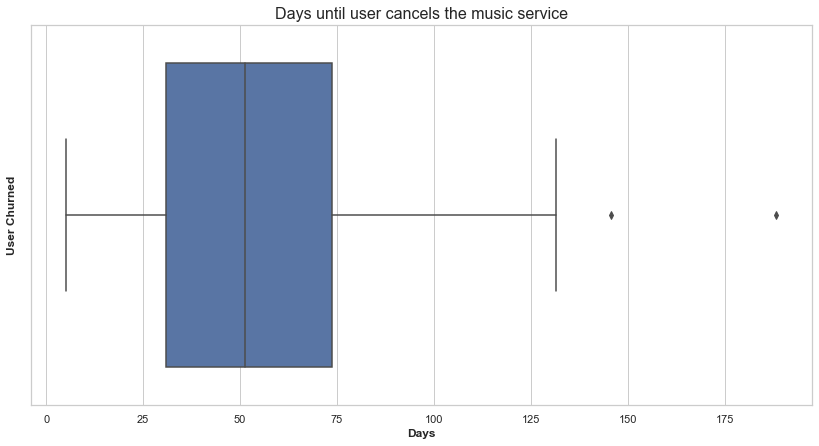

In [372]:
# Average days until user cancels the service
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
ax = sns.boxplot(x='diff_days', orient="h", data=cancel_sparkify_date)
ax.set_title("Days until user cancels the music service", fontsize=16)
ax.set_xlabel("Days", fontsize=12, weight='bold')
ax.set_ylabel("User Churned", fontsize=12, weight='bold');

Let's create a function for drawing boxplots

In [373]:
def draw_boxplot(title = "Thumbs Up per sessionId between users that churned and not",\
                 xlabel = "Number of 'Thumbs Up'", ylabel = "Churn", style="whitegrid", x_data = "count",\
                 y_data = "churn", orientation = "h", df = data):
    '''
    INPUT:
    title - the title of the plot
    xlabel - the name of the x axis
    ylabel - the name of the y axis
    style - style of the plot
    x_data - column to plot in x axis
    y_data - column to plot in y axis
    orientation - select if the boxplot is horizontal or vertical
    df - dataframe with the data
    OUTPUT:
    Boxplot of the data
    
    Takes a dataframe a draw a boxplot of the desired columns
    '''
    plt.figure(figsize=(14, 7))
    sns.set_style(style)
    ax = sns.boxplot(x=x_data, y=y_data, orient=orientation, data=df)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=12, weight='bold')
    ax.set_ylabel(ylabel, fontsize=12, weight='bold')

#### 'Thumbs up' interactions

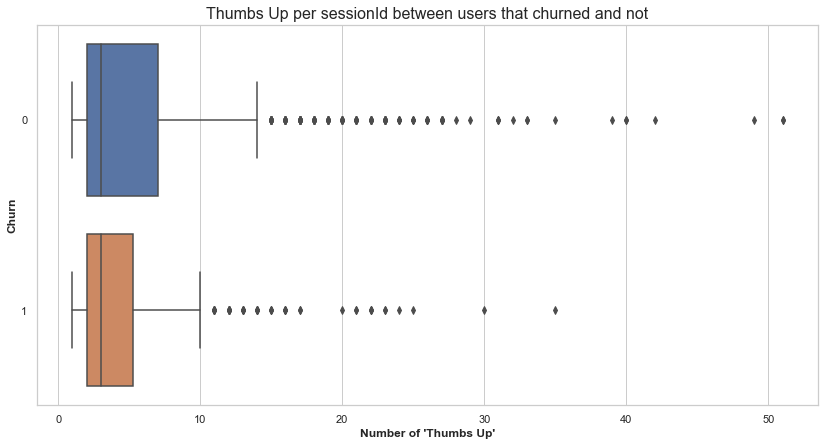

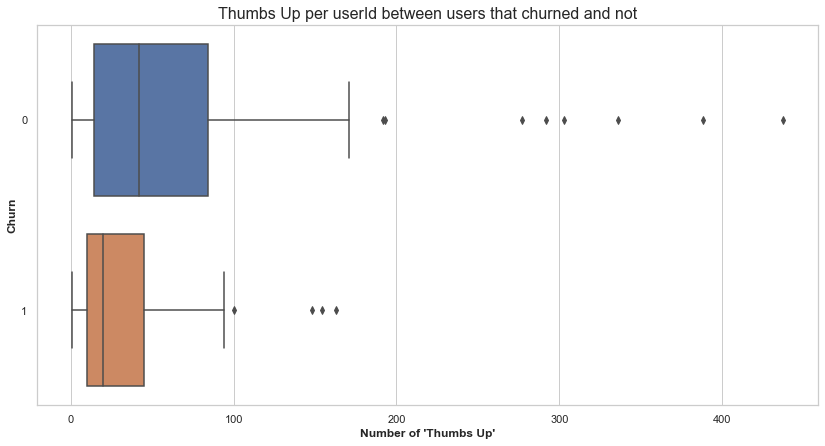

In [374]:
# Thumbs Up per sessionId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Thumbs Up').groupby("userId", "churn", "sessionId").count().toPandas()
draw_boxplot("Thumbs Up per sessionId between users that churned and not", "Number of 'Thumbs Up'",\
             "Churn", "whitegrid", "count", "churn", "h", data)

# Thumbs Up per userId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Thumbs Up').groupby("userId", "churn",).count().toPandas()
draw_boxplot("Thumbs Up per userId between users that churned and not", "Number of 'Thumbs Up'",\
             "Churn", "whitegrid", "count", "churn", "h", data)

#### 'Add Friend' interactions

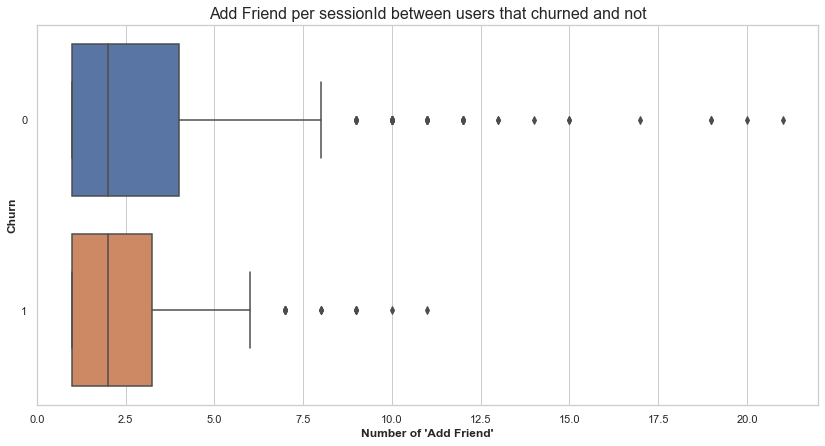

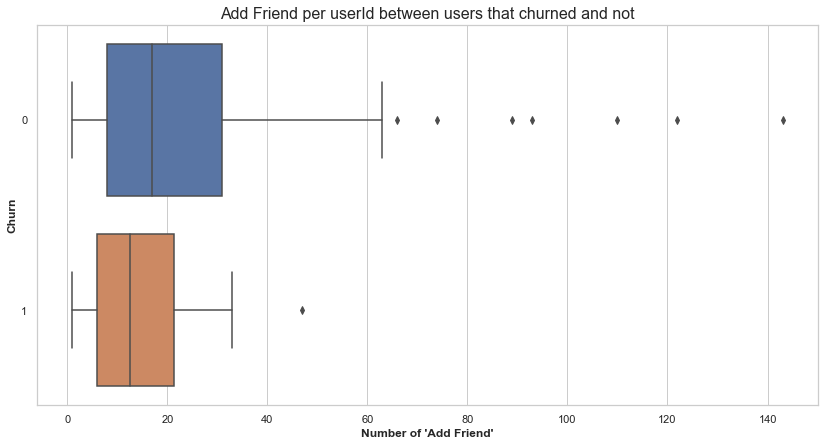

In [375]:
# Add Friend per sessionId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Add Friend').groupby("userId", "churn", "sessionId").count().toPandas()
draw_boxplot("Add Friend per sessionId between users that churned and not", "Number of 'Add Friend'",\
             "Churn", "whitegrid", "count", "churn", "h", data)

# Add Friend per userId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Add Friend').groupby("userId", "churn").count().toPandas()
draw_boxplot("Add Friend per userId between users that churned and not", "Number of 'Add Friend'",\
             "Churn", "whitegrid", "count", "churn", "h", data)

#### 'Help' interactions

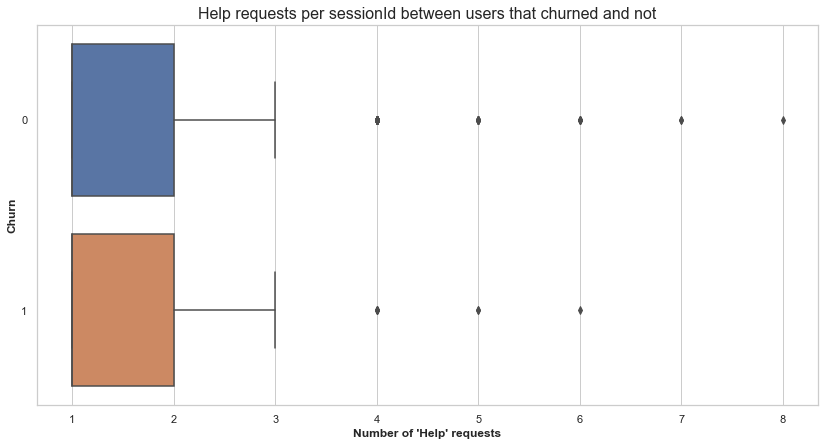

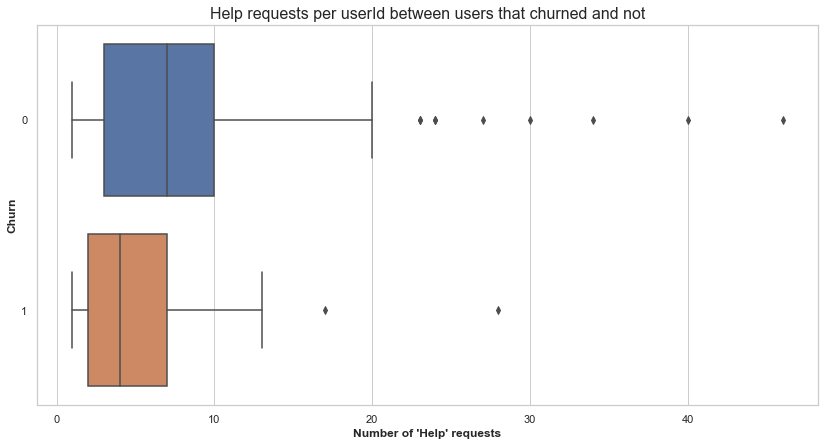

In [376]:
# Help requests per sessionId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Help').groupby("userId", "churn", "sessionId").count().toPandas()
draw_boxplot("Help requests per sessionId between users that churned and not", "Number of 'Help' requests",\
             "Churn", "whitegrid", "count", "churn", "h", data)

# Help requests per userId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Help').groupby("userId", "churn").count().toPandas()
draw_boxplot("Help requests per userId between users that churned and not", "Number of 'Help' requests",\
             "Churn", "whitegrid", "count", "churn", "h", data)

#### 'Next Song' interactions

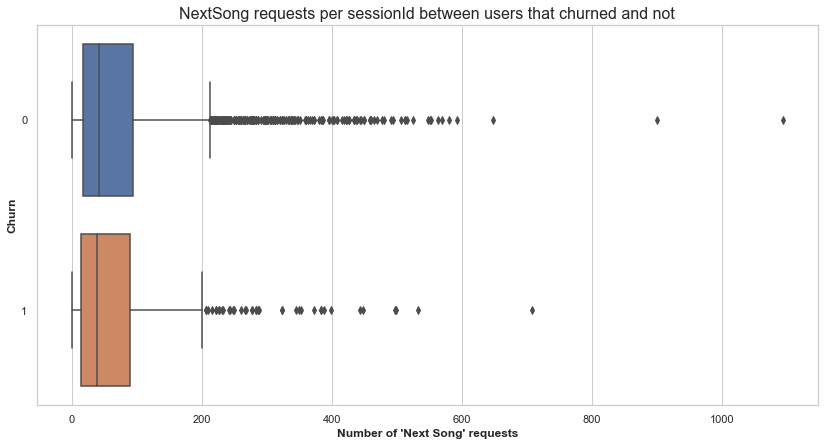

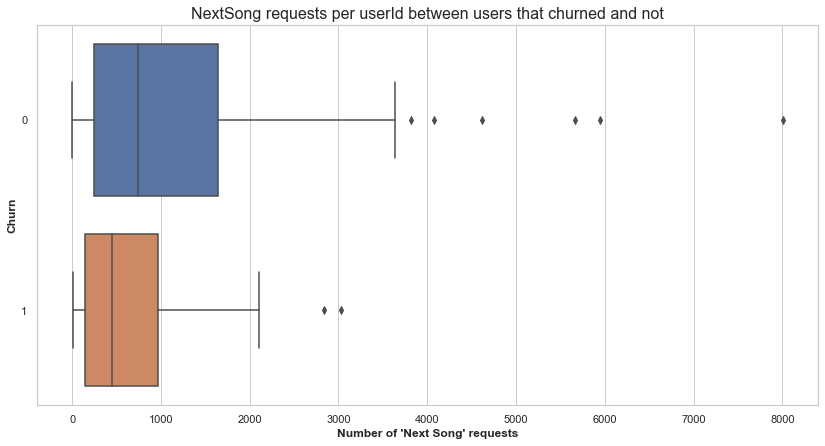

In [378]:
# Next Song per sessionId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'NextSong').groupby("userId", "churn", "sessionId").count().toPandas()
draw_boxplot("NextSong requests per sessionId between users that churned and not", "Number of 'Next Song' requests",\
             "Churn", "whitegrid", "count", "churn", "h", data)

# Next Song per userId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'NextSong').groupby("userId", "churn").count().toPandas()
draw_boxplot("NextSong requests per userId between users that churned and not", "Number of 'Next Song' requests",\
             "Churn", "whitegrid", "count", "churn", "h", data)

#### Churn by device

In [33]:
# User defined function to split the name of the device from the userAgent column
split_device = udf(lambda x: x.split('(')[1].split(';')[0].split(' ')[0])

# Add the column with the device used to sparkify_events
sparkify_events = sparkify_events.withColumn("device", split_device(sparkify_events.userAgent))

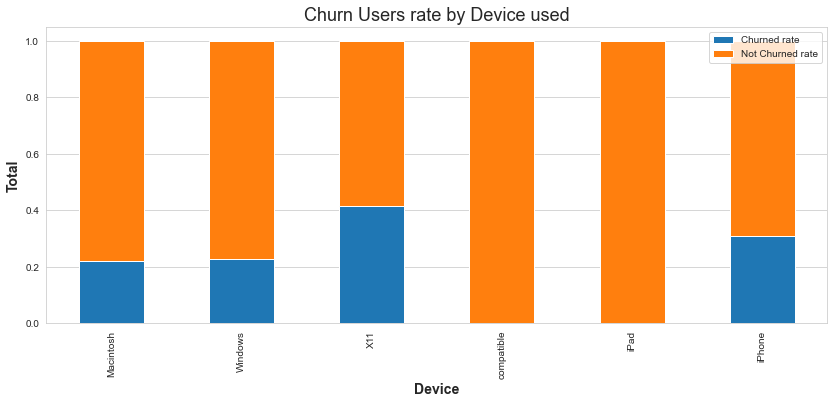

In [34]:
# Group by device and by churn and pivot the table
churn_by_dev = sparkify_events.groupby('device', 'churn').agg(countDistinct('userId')).toPandas()\
               .rename(columns = {'count(userId)':'n_users'}).pivot(index = 'device', \
               columns = 'churn', values = 'n_users').rename(columns = {0:'Not Churned', 1:'Churned'})

# Fill NaN values
churn_by_dev.fillna(0, inplace = True)

# Calculate rates
churn_by_dev['All']= churn_by_dev['Not Churned'] + churn_by_dev['Churned']
churn_by_dev['Churned rate'] = churn_by_dev['Churned'] / churn_by_dev['All']
churn_by_dev['Not Churned rate'] = 1 - churn_by_dev['Churned rate']

# Plot
fig = plt.figure(figsize = (14, 12))
ax1 = fig.add_subplot(2,1,1)
churn_by_dev[['Churned rate','Not Churned rate']].plot(kind = 'bar', ax = ax1, stacked = True)
plt.title('Churn Users rate by Device used', fontsize=16)
plt.ylabel("Total", fontsize=12, fontweight='bold')
plt.xlabel("Device", fontsize=12, fontweight='bold')
plt.legend(loc = 'best')
plt.grid(axis='x')

Now that we have a general vision of the users and how they distribute between churn or not let's start by performing feature engineering that we will use later in the training of the Machine Learning models

# <a class="anchor" id="Feature-Engineering">IV. Feature Engineering</a>

Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Features to be used

1. Listened songs 
2. Average played songs per session
3. Songs added to playlist
4. Total different artists listened
5. Average played time per session
5. Sessions of the user
7. Time passed since registration
8. Friends number
9. Thumbs up
10. Thumbs down
11. Help requests
12. Errors
13. Downgrade
14. Gender
15. Free or paid user
16. Churn

First we will extract the data separately to see that everything works fine

In [35]:
# 1. Listened songs
FE_listened_songs = sparkify_events.select('userID', 'page').where(sparkify_events.page == 'NextSong').groupBy('userID').\
                 count().withColumnRenamed('count', 'songs')

print("The number of rows in '1. Listened songs' is", FE_listened_songs.count())
print("The number of columns in '1. Listened songs' is", len(FE_listened_songs.columns))



# 2. Average played songs per session
FE_avg_songs_session = sparkify_events.where(sparkify_events.song.isNotNull()).groupby(['userId', 'sessionId']).count().\
                       groupby(['userId']).agg({'count': 'avg'}).withColumnRenamed('avg(count)', 'avg_songs_session')

print("The number of rows in '2. Average played songs per session' is", FE_avg_songs_session.count())
print("The number of columns in '2. Average played songs per session' is", len(FE_avg_songs_session.columns))



# 3. Songs added to playlist
FE_add_playlist = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Add to Playlist').\
                  groupBy('userId').count().withColumnRenamed('count', 'add_playlist')

print("The number of rows in '3. Songs added to playlist' is", FE_add_playlist.count())
print("The number of columns in '3. Songs added to playlist' is", len(FE_add_playlist.columns))



# 4. Total different artists listened
FE_dif_artists = sparkify_events.select("userId", "artist").dropDuplicates().groupby("userId").count().\
                 withColumnRenamed('count', 'dif_artists')

print("The number of rows in '4. Total different artists listened' is", FE_dif_artists.count())
print("The number of columns in '4. Total different artists listened' is", len(FE_dif_artists.columns))



# 5. Average played time per session
played_max = sparkify_events.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'max')
played_min = sparkify_events.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'min')
played_session = played_min.join(played_max,['userId', 'sessionId'])
played_session = played_session.select('userId', 'sessionId', ((played_session.max-played_session.min)/(1000*60)).\
                 alias('played_session'))
# Average
FE_played_time_session = played_session.groupBy('userId').agg(avg('played_session').alias('played_time_session'))     
FE_played_time_session = FE_played_time_session.na.fill(0)

print("The number of rows in '5. Average played time per session' is", FE_played_time_session.count())
print("The number of columns in '5. Average played time per session' is", len(FE_played_time_session.columns))



# 6. Sessions of the user
FE_sessions_user = sparkify_events.select("userId", "sessionId").dropDuplicates().groupby("userId").count().\
                   withColumnRenamed('count', 'sessions_user')

print("The number of rows in '6. Sessions of the user' is", FE_sessions_user.count())
print("The number of columns in '6. Sessions of the user' is", len(FE_sessions_user.columns))



# 7. Time passed since registration
latest_time = sparkify_events.groupby("userId").max("ts").sort("userId")
sign_up_moment = sparkify_events.select("userId", "registration").dropDuplicates().sort("userId")
FE_time_since_registration = sign_up_moment.join(latest_time, sign_up_moment.userId == latest_time.userId).\
                             select(sign_up_moment["userId"], ((latest_time["max(ts)"]-sign_up_moment["registration"])/(1000*60)).\
                             alias("registration_min"))

print("The number of rows in '7. Time passed since registration' is", FE_time_since_registration.count())
print("The number of columns in '7. Time passed since registration' is", len(FE_time_since_registration.columns))



# 8. Friends number
FE_friends = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Add Friend').groupBy('userId').\
            count().withColumnRenamed('count', 'friend').sort('userId')

print("The number of rows in '8. Friends number' is", FE_friends.count())
print("The number of columns in '8. Friends number' is", len(FE_friends.columns))



# 9. Thumbs up
FE_thumbs_up = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Thumbs Up').groupBy('userId').\
            count().withColumnRenamed('count', 'thumbs_up')

print("The number of rows in '9. Thumbs up' is", FE_thumbs_up.count())
print("The number of columns in '9. Thumbs up' is", len(FE_thumbs_up.columns))



# 10. Thumbs down
FE_thumbs_down = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Thumbs Down').groupBy('userId').\
            count().withColumnRenamed('count', 'thumbs_down')

print("The number of rows in '10. Thumbs down' is", FE_thumbs_down.count())
print("The number of columns in '10. Thumbs down' is", len(FE_thumbs_down.columns))



# 11. Help requests
FE_help = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Help').groupBy('userId').\
            count().withColumnRenamed('count', 'help')

print("The number of rows in '11. Help requests' is", FE_help.count())
print("The number of columns in '11. Help requests' is", len(FE_help.columns))



# 12. Errors
FE_errors = sparkify_events.select('userId', 'page').where(sparkify_events.page == 'Error').groupBy('userId').\
            count().withColumnRenamed('count', 'errors')

print("The number of rows in '12. Errors' is", FE_errors.count())
print("The number of columns in '12. Errors' is", len(FE_errors.columns))



# 13. Downgrade
FE_downgrade = sparkify_events["userId", "downgrade"].dropDuplicates()

print("The number of rows in '13. Downgrade' is", FE_downgrade.count())
print("The number of columns in '13. Downgrade' is", len(FE_downgrade.columns))



# 14. Gender
FE_gender = sparkify_events.groupby('userId').agg(first(when(sparkify_events.gender == "F", 1).otherwise(0)).alias('gender'))

print("The number of rows in '14. Gender' is", FE_gender.count())
print("The number of columns in '14. Gender' is", len(FE_gender.columns))



# 15. Free or paid user
FE_level = sparkify_events.groupby('userId').agg(last(when(sparkify_events.level == 'paid', 1).otherwise(0)).\
           alias('level'))

print("The number of rows in '15. Free or paid user' is", FE_level.count())
print("The number of columns in '15. Free or paid user' is", len(FE_level.columns))



# 16. Churn
FE_churn = sparkify_events.select('userId', 'churn').dropDuplicates()

print("The number of rows in '16. Churn' is", FE_churn.count())
print("The number of columns in '16. Churn' is", len(FE_churn.columns))

The number of rows in '1. Listened songs' is 225
The number of columns in '1. Listened songs' is 2
The number of rows in '2. Average played songs per session' is 225
The number of columns in '2. Average played songs per session' is 2
The number of rows in '3. Songs added to playlist' is 215
The number of columns in '3. Songs added to playlist' is 2
The number of rows in '4. Total different artists listened' is 225
The number of columns in '4. Total different artists listened' is 2
The number of rows in '5. Average played time per session' is 225
The number of columns in '5. Average played time per session' is 2
The number of rows in '6. Sessions of the user' is 225
The number of columns in '6. Sessions of the user' is 2
The number of rows in '7. Time passed since registration' is 225
The number of columns in '7. Time passed since registration' is 2
The number of rows in '8. Friends number' is 206
The number of columns in '8. Friends number' is 2
The number of rows in '9. Thumbs up' is 

Let's create a function to join all the selected features

In [36]:
def features(df):
    '''
    INPUT:
    df - dataframe with the data
    OUTPUT:
    FE_data - dataframe with the selected features
    
    Function that takes the selected features from the original dataset and put them in a new variable to be used
    with the Machine Learning algorithms
    '''
    
    print("Extraction of features started")
    start = datetime.datetime.now()
    
    # 1. Listened songs
    print('1. Listened songs')
    FE_listened_songs = df.select('userID', 'page').where(df.page == 'NextSong').groupBy('userID').\
                 count().withColumnRenamed('count', 'songs')

    # 2. Average played songs per session
    print("2. Average played songs per session")
    FE_avg_songs_session = df.where(df.song.isNotNull()).groupby(['userId', 'sessionId']).count().\
                           groupby(['userId']).agg({'count': 'avg'}).withColumnRenamed('avg(count)', 'avg_songs_session')

    # 3. Songs added to playlist
    print("3. Songs added to playlist")
    FE_add_playlist = df.select('userId', 'page').where(df.page == 'Add to Playlist').\
                      groupBy('userId').count().withColumnRenamed('count', 'add_playlist')

    # 4. Total different artists listened
    print("4. Total different artists listened")
    FE_dif_artists = df.select("userId", "artist").dropDuplicates().groupby("userId").count().\
                     withColumnRenamed('count', 'dif_artists')

    # 5. Average played time per session
    print("5. Average played time per session")
    played_max = df.groupBy('userId', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'max')
    played_min = df.groupBy('userId', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'min')
    played_session = played_min.join(played_max,['userId', 'sessionId'])
    played_session = played_session.select('userId', 'sessionId', ((played_session.max-played_session.min)/(1000*60)).\
                     alias('played_session'))
    # Average
    FE_played_time_session = played_session.groupBy('userId').agg(avg('played_session').alias('played_time_session'))     
    FE_played_time_session = FE_played_time_session.na.fill(0)

    # 6. Sessions of the user
    print("6. Sessions of the user")
    FE_sessions_user = df.select("userId", "sessionId").dropDuplicates().groupby("userId").count().\
                       withColumnRenamed('count', 'sessions_user')

    # 7. Time passed since registration
    print("7. Time passed since registration")
    latest_time = df.groupby("userId").max("ts").sort("userId")
    sign_up_moment = df.select("userId", "registration").dropDuplicates().sort("userId")
    FE_time_since_registration = sign_up_moment.join(latest_time, sign_up_moment.userId == latest_time.userId).\
                                 select(sign_up_moment["userId"], ((latest_time["max(ts)"]-sign_up_moment["registration"])/(1000*60)).\
                                 alias("registration_min"))

    # 8. Friends number
    print("8. Friends number")
    FE_friends = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').\
                count().withColumnRenamed('count', 'friend').sort('userId')

    # 9. Thumbs up
    print("9. Thumbs up")
    FE_thumbs_up = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').\
                count().withColumnRenamed('count', 'thumbs_up')

    # 10. Thumbs down
    print("10. Thumbs down")
    FE_thumbs_down = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').\
                count().withColumnRenamed('count', 'thumbs_down')

    # 11. Help requests
    print("11. Help requests")
    FE_help = df.select('userId', 'page').where(df.page == 'Help').groupBy('userId').\
                count().withColumnRenamed('count', 'help')

    # 12. Errors
    print("12. Errors")
    FE_errors = df.select('userId', 'page').where(df.page == 'Error').groupBy('userId').\
                count().withColumnRenamed('count', 'errors')

    # 13. Downgrade
    print("13. Downgrade")
    FE_downgrade = df["userId", "downgrade"].dropDuplicates()

    # 14. Gender
    print("14. Gender")
    FE_gender = df.groupby('userId').agg(first(when(df.gender == "F", 1).otherwise(0)).alias('gender'))

    # 15. Free or paid user
    print("15. Free or paid user")
    FE_level = df.groupby('userId').agg(last(when(df.level == 'paid', 1).otherwise(0)).\
               alias('level'))

    # 16. Churn
    print("16. Churn")
    FE_churn = df.select('userId', 'churn').dropDuplicates()
    
    # Feature join in one dataframe
    print("\n")
    print("Joining of selected features in process...")
    FE_data = FE_listened_songs.join(FE_avg_songs_session,'userID','outer').\
                                join(FE_add_playlist,'userID','outer').\
                                join(FE_dif_artists,'userID','outer').\
                                join(FE_played_time_session,'userID','outer').\
                                join(FE_sessions_user,'userID','outer').\
                                join(FE_time_since_registration,'userID','outer').\
                                join(FE_friends,'userID','outer').\
                                join(FE_thumbs_up,'userID','outer').\
                                join(FE_thumbs_down,'userID','outer').\
                                join(FE_help,'userID','outer').\
                                join(FE_errors,'userID','outer').\
                                join(FE_downgrade,'userID','outer').\
                                join(FE_gender,'userID','outer').\
                                join(FE_level,'userID','outer').\
                                join(FE_churn,'userID','outer').\
                                drop('userID').\
                                fillna(0)

    print ("The resulting dataframe has",FE_data.count(), "rows and ",len(FE_data.dtypes),"columns")
    print("Feature join finished")
    print("\n")
    print ("The process took",datetime.datetime.now()-start,"s")
    
    return FE_data

In [37]:
df_features = features(sparkify_events)

Extraction of features started
1. Listened songs
2. Average played songs per session
3. Songs added to playlist
4. Total different artists listened
5. Average played time per session
6. Sessions of the user
7. Time passed since registration
8. Friends number
9. Thumbs up
10. Thumbs down
11. Help requests
12. Errors
13. Downgrade
14. Gender
15. Free or paid user
16. Churn


Joining of selected features in process...
The resulting dataframe has 225 rows and  16 columns
Feature join finished


The process took 0:00:25.893064 s


# <a class="anchor" id="Modeling">V. Modeling</a>

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### <a class="anchor" id="Data-preparation">Data preparation</a>

In [212]:
# Show the first 10 rows of the data
ten_rows_print = df_features.limit(10).toPandas()
ten_rows_print

,songs,avg_songs_session,add_playlist,dif_artists,played_time_session,sessions_user,registration_min,friend,thumbs_up,thumbs_down,help,errors,downgrade,gender,level,churn
0,275,39.285714,7,253,154.483333,7,80126.866667,4,17,5,2,0,0,1,0,0
1,387,64.500000,8,340,266.400000,6,100907.466667,4,21,6,2,0,5,0,1,0
2,8,8.000000,0,9,29.566667,1,102696.316667,0,0,0,0,0,0,0,0,1
3,4079,145.678571,118,2233,578.994253,29,189440.516667,74,171,41,23,6,41,1,1,0
4,2111,211.100000,52,1386,872.356667,10,28016.416667,28,100,21,12,1,23,0,1,1
5,150,21.428571,5,143,87.640476,7,104800.583333,1,7,1,1,1,0,0,0,0
6,1914,136.714286,59,1303,528.283333,15,81379.550000,31,81,14,8,2,28,0,1,0
7,2841,81.171429,72,1745,322.289640,37,159482.433333,33,163,29,17,1,39,1,1,1
8,820,136.666667,24,644,548.572222,6,33920.666667,11,58,3,9,3,12,1,1,0
9,257,42.833333,7,234,184.813889,6,122520.100000,6,17,3,2,0,3,0,1,1


In [213]:
def churn_and_Schema(df):
    '''
    INPUT:
    df - dataframe with the data
    OUTPUT:
    
    Function that shows the churn count in the dataset and the Schema
    '''
    
    # Print Churn count
    df.groupby("churn").count().show()

    #Print type of features
    df.printSchema()

In [214]:
# Data conversion to integer and float
def convert_int_float(df, int_features, float_features):
    '''
    INPUT:
    df - dataframe with the data
    int_features - list with the variables to be converted to integer
    float_features - list with the variables to be converted to float
    OUTPUT:
    df_features_i_f - dataframe with the converted features
    
    Function that convert each column to the desired integer or float format
    '''

    df_features_i_f = df

    # Integer
    for col in int_features:
        df_features_i_f = df_features_i_f.withColumn(col, df_features_i_f[col].cast(IntegerType()))

    # Float
    for col in float_features:
        df_features_i_f = df_features_i_f.withColumn(col, df_features_i_f[col].cast(FloatType()))
        
    return df_features_i_f

In [215]:
def feature_scale(df):
    '''
    INPUT:
    df - dataframe with the data
    OUTPUT:
    df_features_scaled - dataframe with the selected features scaled
    
    Function that scales the features to be used in the Machine Learning algorithm
    '''
    
    start = datetime.datetime.now()
        
    features_mod = ["songs", "avg_songs_session",  "add_playlist", "dif_artists", "played_time_session",\
                    "sessions_user", "registration_min", "friend", "thumbs_up", "thumbs_down", "help",\
                    "errors", "downgrade", "gender", "level"]

    print("Executing VectorAssembler...")
    vec_assembler = VectorAssembler(inputCols=features_mod, outputCol="Features")
    df_features_i_f_assembled = vec_assembler.transform(df)

    print("Executing StandardScaler...")
    scaled = StandardScaler(inputCol='Features', outputCol='scaled_features', withMean=True, withStd=True)

    print("Fit...")
    scaled_fit = scaled.fit(df_features_i_f_assembled)
    print("Transform...")
    df_features_i_f_scaled = scaled_fit.transform(df_features_i_f_assembled)

    print("Joining features...")
    df_features_scaled = df_features_i_f_scaled.select(df_features_i_f_assembled.churn.alias('label'),\
                         df_features_i_f_scaled.scaled_features.alias('features'))
    
    print("Feature scale finished")
    print("\n")
    print ("The process took",datetime.datetime.now()-start,"seconds")
    
    return df_features_scaled

In [216]:
print("The current full dataset have", df_features.count(), "rows")
print("The current full dataset have", len(df_features.columns), "colums")
print("\n")
print("Select in the next cell how many rows should be kept to train the Machine Learning model")

The current full dataset have 225 rows
The current full dataset have 16 colums


Select in the next cell how many rows should be kept to train the Machine Learning model


In [240]:
# Define the number of rows that will be selected to use in the Machine Learning model (usefull to test that the
# model works fine with less execution time)
n_rows = 225
print("The dataset will be limited to", n_rows, "rows")

# Limit the number of rows to be used in the Machine Learning model
df_features_rows = df_features.limit(n_rows)

The dataset will be limited to 225 rows


In [241]:
# Look at the properties of the current data that we have selected
churn_and_Schema(df_features_rows)

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+

root
 |-- songs: long (nullable = true)
 |-- avg_songs_session: double (nullable = false)
 |-- add_playlist: long (nullable = true)
 |-- dif_artists: long (nullable = true)
 |-- played_time_session: double (nullable = false)
 |-- sessions_user: long (nullable = true)
 |-- registration_min: double (nullable = false)
 |-- friend: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- help: long (nullable = true)
 |-- errors: long (nullable = true)
 |-- downgrade: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- churn: long (nullable = true)



First we will convert all variables to integer or float

In [242]:
# Specify the colums to be converted
FE_int = ["songs", "add_playlist", "dif_artists", "sessions_user", "friend", "thumbs_up", "thumbs_down", "help",
          "errors", "downgrade", "gender", "level", "churn"]
FE_float = ["avg_songs_session","played_time_session","registration_min"]


df_features_i_f = convert_int_float(df_features_rows, FE_int, FE_float)
df_features_i_f.printSchema()

root
 |-- songs: integer (nullable = true)
 |-- avg_songs_session: float (nullable = false)
 |-- add_playlist: integer (nullable = true)
 |-- dif_artists: integer (nullable = true)
 |-- played_time_session: float (nullable = false)
 |-- sessions_user: integer (nullable = true)
 |-- registration_min: float (nullable = false)
 |-- friend: integer (nullable = true)
 |-- thumbs_up: integer (nullable = true)
 |-- thumbs_down: integer (nullable = true)
 |-- help: integer (nullable = true)
 |-- errors: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- churn: integer (nullable = true)



Then we can apply the feature scaling function to the data

In [243]:
df_features_scaled = feature_scale(df_features_i_f)

Executing VectorAssembler...
Executing StandardScaler...
Fit...
Transform...
Joining features...
Feature scale finished


The process took 0:00:25.525817 seconds


In [244]:
df_features_scaled.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-0.6686330842440...|
|    0|[-0.5672720204182...|
|    1|[-0.9102706203287...|
|    0|[2.77402304783854...|
|    1|[0.99296435489991...|
|    0|[-0.7817592715496...|
|    0|[0.81467748370636...|
|    1|[1.65362128876434...|
|    0|[-0.1754029075918...|
|    1|[-0.6849232552160...|
+-----+--------------------+
only showing top 10 rows



In [245]:
print("The number of rows in the dataframe is", df_features_scaled.count())
print("The number of columns in the dataframe is", len(df_features_scaled.columns))

The number of rows in the dataframe is 225
The number of columns in the dataframe is 2


In [246]:
# Split data in train and test datasets
train, test = df_features_scaled.randomSplit([0.8, 0.2], seed=42)

### <a class="anchor" id="Machine-Learning-models">Machine Learning models</a>

We well start by defining the necessary functions to train different models. The documentation used can be found under https://spark.apache.org/docs/latest/ml-classification-regression.html

In [255]:
def train_predict_ML_model(train, test, ML_model):
    '''
    INPUT:
    train - train dataset
    test - test dataset
    OUTPUT:
    accuracy - accuracy score
    f1score - f1 score
    elapsed_time - time spent in training the model
    
    Function that train a Random Forest model on the train and test datasets
    '''
    
    ## Random Forest model
    start = datetime.datetime.now()
    
    if ML_model == "Random Forest":
    
        print("Random Forest model Initialization")
        model = RandomForestClassifier(labelCol = "label", featuresCol = "features")
        print("GridBuilder")
        paramGrid = ParamGridBuilder().addGrid(model.maxDepth, [5, 10]).\
                                       addGrid(model.numTrees, [10, 20]).\
                                       addGrid(model.impurity, ['entropy', 'gini']).\
                                       build()
        
    elif ML_model == "Logistic Regression":
        print("Logistic Regression model Initialization")
        model = LogisticRegression(labelCol = "label", featuresCol = "features", maxIter = 10)
        print("GridBuilder")
        paramGrid = ParamGridBuilder().addGrid(model.elasticNetParam, [0.0, 0.2, 0.6, 1.0]).\
                                       addGrid(model.regParam, [0.02, 0.06, 0.1]).\
                                       build()
        
    elif ML_model == "Decision Tree":
        print("Decision Tree model Initialization")
        model = DecisionTreeClassifier(labelCol = "label", featuresCol = "features", seed = 42)
        print("GridBuilder")
        paramGrid = ParamGridBuilder().addGrid(model.impurity, ['entropy', 'gini']).\
                                       addGrid(model.maxDepth, [2, 3, 5, 8, 13, 21, 30]).\
                                       build()

    elif ML_model == "Gradient Boosted Trees":
        print("Gradient Boosted Trees model Initialization")
        model = GBTClassifier(labelCol = "label", featuresCol = "features", maxIter = 10, seed = 42)
        print("GridBuilder")
        paramGrid = ParamGridBuilder().addGrid(model.maxDepth, [3, 5, 7]).\
                                       addGrid(model.maxIter, [6, 12]).\
                                       build()
        
    elif ML_model == "LinearSVC":
        print("LinearSVC model Initialization")
        model = LinearSVC(labelCol = "label", featuresCol = "features")
        print("GridBuilder")
        paramGrid = ParamGridBuilder().addGrid(model.maxIter, [6, 12]).\
                                       addGrid(model.regParam, [0.02, 0.06, 0.1]).\
                                       build()

    else:
        BOLD = '\033[1m'
        print(BOLD + "The specified model is not yet implemented. Select another model from the list" + BOLD)
        return
    
    
    print("F1 score evaluation")
    f1_eval = MulticlassClassificationEvaluator(metricName = 'f1')
    
    print("Cross Validation")
    crossval = CrossValidator(estimator = model, estimatorParamMaps = paramGrid, evaluator = f1_eval, numFolds = 3)
    
    print("Fit Model")
    model_fit = crossval.fit(train)
    
    print("Transform")
    results = model_fit.transform(test)
    
    print("Evaluation of the model")
    evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
    
    # Results
    accuracy = evaluator.evaluate(results, {evaluator.metricName: "accuracy"})
    f1score = evaluator.evaluate(results, {evaluator.metricName: "f1"})
    end = datetime.datetime.now()
    elapsed_time = (end - start)#.total_seconds()
    
    print("Model training finished")
    print ("The process took",end - start,"minutes")
    print("\n")
   
    return ML_model, accuracy, f1score, elapsed_time, model_fit;

In [256]:
def train_model_execution(train, test):
    '''
    INPUT:
    train - train dataset
    test - test dataset
    OUTPUT:
    model_name - model name used
    accuracy - accuracy score
    f1score - f1 score
    elapsed_time - time spent in training the model
    
    Function that train 5 machine learning models on the train and test datasets
    '''
    
    # Define variables used to save the results obtained
    model_name = []
    accuracy = []
    f1score = []
    elapsed_time = []
    model_fit = []
    
    model_nam, acc, f1s, elapsed_t, model_f = train_predict_ML_model(train, test, "Random Forest")
    model_name.append(model_nam)
    accuracy.append(acc)
    f1score.append(f1s)
    elapsed_time.append(elapsed_t)
    model_fit.append(model_f)
    
    model_nam, acc, f1s, elapsed_t, model_f = train_predict_ML_model(train, test, "Logistic Regression")
    model_name.append(model_nam)
    accuracy.append(acc)
    f1score.append(f1s)
    elapsed_time.append(elapsed_t)
    model_fit.append(model_f)
    
    model_nam, acc, f1s, elapsed_t, model_f = train_predict_ML_model(train, test, "Decision Tree")
    model_name.append(model_nam)
    accuracy.append(acc)
    f1score.append(f1s)
    elapsed_time.append(elapsed_t)
    model_fit.append(model_f)
    
    model_nam, acc, f1s, elapsed_t, model_f = train_predict_ML_model(train, test, "Gradient Boosted Trees")
    model_name.append(model_nam)
    accuracy.append(acc)
    f1score.append(f1s)
    elapsed_time.append(elapsed_t)
    model_fit.append(model_f)
    
    model_nam, acc, f1s, elapsed_t, model_f = train_predict_ML_model(train, test, "LinearSVC")
    model_name.append(model_nam)
    accuracy.append(acc)
    f1score.append(f1s)
    elapsed_time.append(elapsed_t)
    model_fit.append(model_f)
    
    return model_name, accuracy, f1score, elapsed_time, model_fit

Here will be trained all the models specified at once

In [249]:
# Execute the function that will train all the models
model_name, accuracy, f1score, elapsed_time, model_fit = train_model_execution(train, test)

Random Forest model Initialization
GridBuilder
F1 score evaluation
Cross Validation
Fit Model
Transform
Evaluation of the model
Model training finished
The process took 0:04:34.036536 minutes


Logistic Regression model Initialization
GridBuilder
F1 score evaluation
Cross Validation
Fit Model
Transform
Evaluation of the model
Model training finished
The process took 0:04:08.942884 minutes


Decision Tree model Initialization
GridBuilder
F1 score evaluation
Cross Validation
Fit Model
Transform
Evaluation of the model
Model training finished
The process took 0:04:47.750021 minutes


Gradient Boosted Trees model Initialization
GridBuilder
F1 score evaluation
Cross Validation
Fit Model
Transform
Evaluation of the model
Model training finished
The process took 0:04:24.014526 minutes


LinearSVC model Initialization
GridBuilder
F1 score evaluation
Cross Validation
Fit Model
Transform
Evaluation of the model
Model training finished
The process took 0:04:04.784299 minutes




### <a class="anchor" id="Results">Results</a>

In this part we will present the results obtained

In [260]:
def results(model_name, accuracy, f1score, elapsed_time):
    '''
    INPUT:
    train - train dataset
    test - test dataset
    OUTPUT:
    model_name - model name used
    accuracy - accuracy score
    f1score - f1 score
    elapsed_time - time spent in training the model
    
    Function that plots the results obtained in the training of the Machine Learning models
    '''
    
    # Dataframe with the results obtained for each model
    results = pd.DataFrame(columns = ['Model name', 'Accuracy', 'f1score','Training time (h:m:s)'])
    results['Model name'] = model_name
    results['Accuracy'] = accuracy
    results['f1score'] = f1score
    results['Training time (h:m:s)'] = elapsed_time
    
    print(results.to_string(index=False))
    
    # Plot Accuracy
    plt.figure(figsize = (12, 6))
    sns.set(style = "whitegrid")
    ax = sns.barplot(x = 'Model name', y = 'Accuracy', orient = "v", data = results)
    ax.set_title("Accuracy of the models used", fontsize = 16)
    ax.set_xlabel("Model Name", fontsize = 12, weight = 'bold')
    ax.set_ylabel("Accuracy", fontsize = 12, weight = 'bold')
    ax.set_ylim(0, 1)
    for m in ax.patches:
        ax.annotate(format(m.get_height(), '.4f'), (m.get_x() + m.get_width() / 2.,
                           m.get_height()), ha = 'center', va = 'center', xytext = (0, 12),
                           textcoords = 'offset points')
    
    # Plot F1score
    plt.figure(figsize = (12, 6))
    sns.set(style = "whitegrid")
    ax = sns.barplot(x = 'Model name', y = 'f1score', orient = "v", data = results)
    ax.set_title("f1score of the models used", fontsize = 16)
    ax.set_xlabel("Model Name", fontsize = 12, weight = 'bold')
    ax.set_ylabel("f1score", fontsize = 12, weight = 'bold')
    ax.set_ylim(0, 1)
    for m in ax.patches:
        ax.annotate(format(m.get_height(), '.4f'), (m.get_x() + m.get_width() / 2.,
                           m.get_height()), ha = 'center', va = 'center', xytext = (0, 12),
                           textcoords = 'offset points')
    
    return;

             Model name  Accuracy   f1score  Training time (h:m:s)
          Random Forest  0.800000  0.736508 0 days 00:04:34.036536
    Logistic Regression  0.885714  0.860829 0 days 00:04:08.942884
          Decision Tree  0.800000  0.805938 0 days 00:04:47.750021
 Gradient Boosted Trees  0.685714  0.717108 0 days 00:04:24.014526
              LinearSVC  0.828571  0.750893 0 days 00:04:04.784299


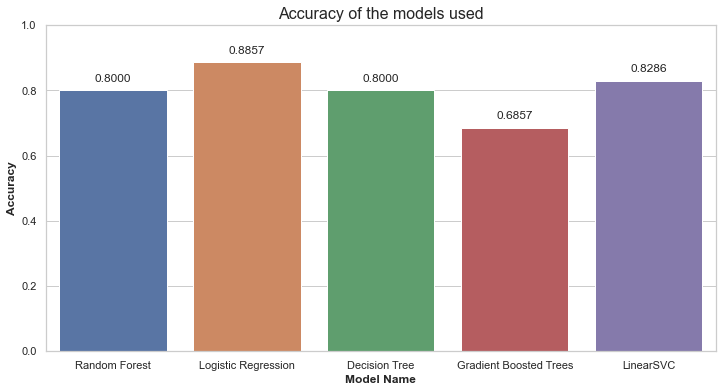

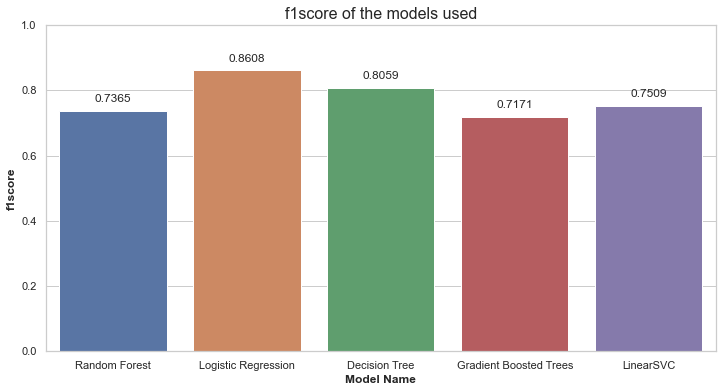

In [261]:
results(model_name, accuracy, f1score, np.array(elapsed_time))

From the results obtained for the different models can be seen that the one performing the best is Logistic Regression with accuracy and f1 score values of 0.885714 and 0.860829 respectively

Now let's represent the value of the coefficients of the best model that obtained the aforementioned scores

In [387]:
model_fit[1].bestModel

LogisticRegressionModel: uid=LogisticRegression_fac5e81906c0, numClasses=2, numFeatures=15

In [382]:
model_fit[1].bestModel.regParam

Param(parent='LogisticRegression_fac5e81906c0', name='regParam', doc='regularization parameter (>= 0).')

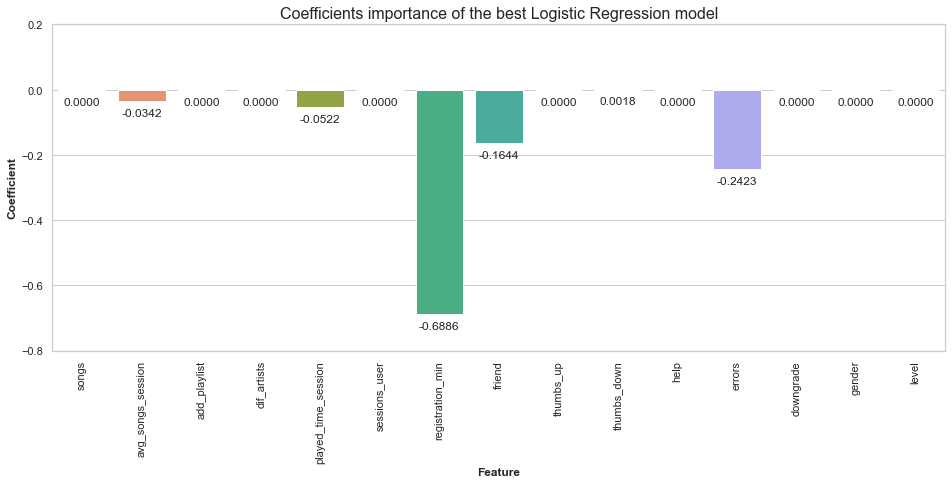

In [380]:
model_best = model_fit[1].bestModel

coeff = []
for i in model_best.coefficients:
    coeff.append(i)

features = ["songs", "avg_songs_session", "add_playlist", "dif_artists", "played_time_session", "sessions_user",
            "registration_min", "friend", "thumbs_up", "thumbs_down", "help", "errors", "downgrade", "gender",
            "level"]

LR_coeff = pd.DataFrame()
LR_coeff['features'] = features
LR_coeff['coeff'] = coeff

# Plot coefficients
plt.figure(figsize = (16, 6))
sns.set(style = "whitegrid")
ax = sns.barplot(x = 'features', y = 'coeff', data = LR_coeff)
ax.set_title("Coefficients importance of the best Logistic Regression model", fontsize = 16)
ax.set_xlabel("Feature", fontsize = 12, weight = 'bold')
ax.set_ylabel("Coefficient", fontsize = 12, weight = 'bold')
ax.set_xticklabels(labels = LR_coeff['features'],rotation = 90)
ax.set_ylim(-0.8, 0.2)
for m in ax.patches:
        ax.annotate(format(m.get_height(), '.4f'), (m.get_x() + m.get_width() / 2., 
                           m.get_height()), ha = 'center', va = 'center', xytext = (0, -12), 
                           textcoords = 'offset points')

As can be seen, there are 6 coefficients that have an impact in the decission of the user to churn or not. A negative sign means that an user is less likely to churn while more negative the number is.
If we order them from the one with the most importance to the less one, we obtain:
1. registration_min
2. errors
3. friend
4. played_time_session
5. avg_songs_session
6. thumbs_down

Let's represent these values for each userId for the features above

#### 1. registration_min

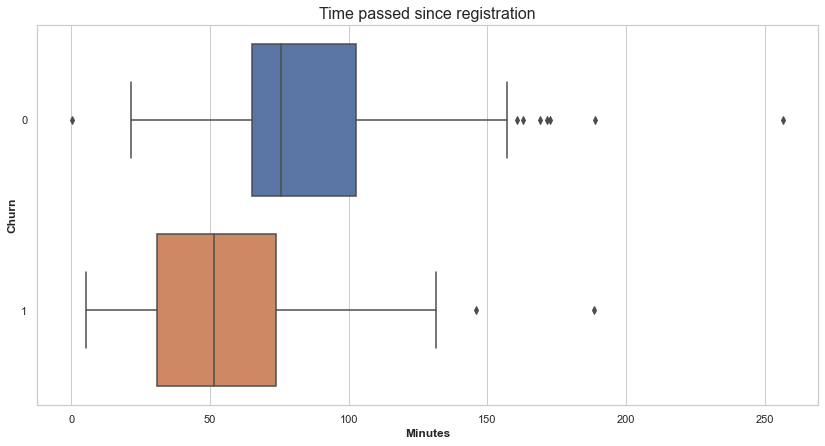

In [323]:
latest_time = sparkify_events.groupby("userId", "churn").max("ts").sort("userId")
sign_up_moment = sparkify_events.select("userId", "registration", "churn").dropDuplicates().sort("userId")
FE_time_since_registration = sign_up_moment.join(latest_time, sign_up_moment.userId == latest_time.userId).\
                             select(sign_up_moment["userId"], sign_up_moment["churn"], 
                             ((latest_time["max(ts)"]-sign_up_moment["registration"])/(1000*60*60*24)).\
                             alias("registration_min")).toPandas()

draw_boxplot("Time passed since registration", "Minutes",\
             "Churn", "whitegrid", "registration_min", "churn", "h", FE_time_since_registration)

#### 2. errors

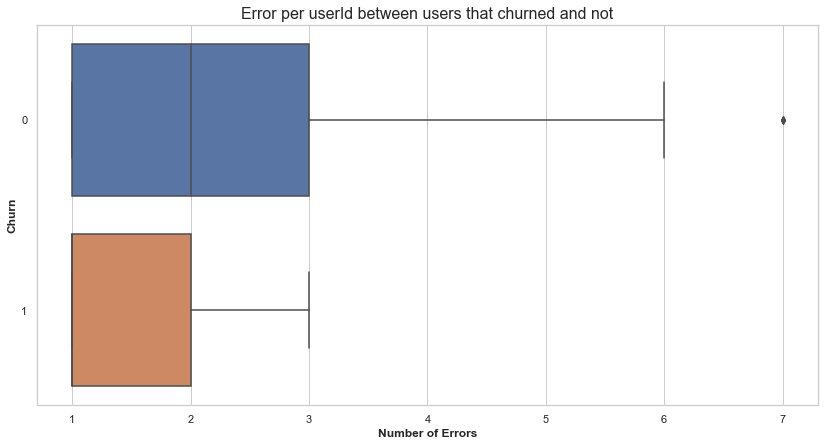

In [335]:
# Errors per userId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Error').groupby("userId", "churn").count().toPandas()
draw_boxplot("Error per userId between users that churned and not", "Number of Errors",\
             "Churn", "whitegrid", "count", "churn", "h", data)

#### 3. friends

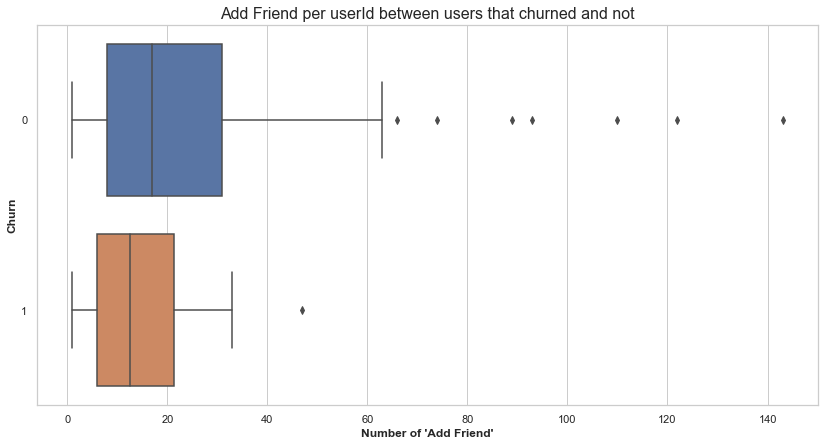

In [324]:
# Add Friend per userId and churn
data = sparkify_events.filter(sparkify_events['page'] == 'Add Friend').groupby("userId", "churn").count().toPandas()
draw_boxplot("Add Friend per userId between users that churned and not", "Number of 'Add Friend'",\
             "Churn", "whitegrid", "count", "churn", "h", data)

#### 4. played_time_session

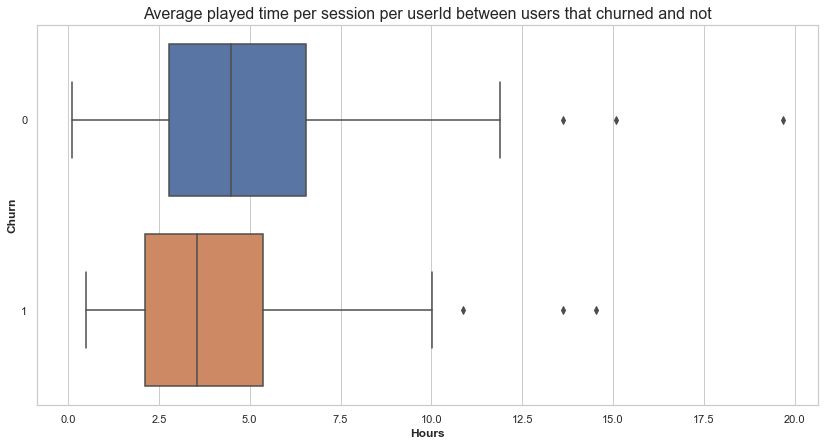

In [342]:
played_max = sparkify_events.groupBy('userId', 'churn', 'sessionId').max('ts').withColumnRenamed('max(ts)', 'max')
played_min = sparkify_events.groupBy('userId','churn', 'sessionId').min('ts').withColumnRenamed('min(ts)', 'min')
played_session = played_min.join(played_max,['userId', 'churn', 'sessionId'])
played_session = played_session.select('userId', 'churn', 'sessionId', ((played_session.max-played_session.min)/(1000*60*60)).\
                 alias('played_session'))

layed_time_session = played_session.groupBy('userId', 'churn').agg(avg('played_session').alias('played_time_session'))     
layed_time_session = layed_time_session.na.fill(0).toPandas()
layed_time_session

draw_boxplot("Average played time per session per userId between users that churned and not", "Hours",\
             "Churn", "whitegrid", "played_time_session", "churn", "h", layed_time_session)

#### 5. avg_songs_session

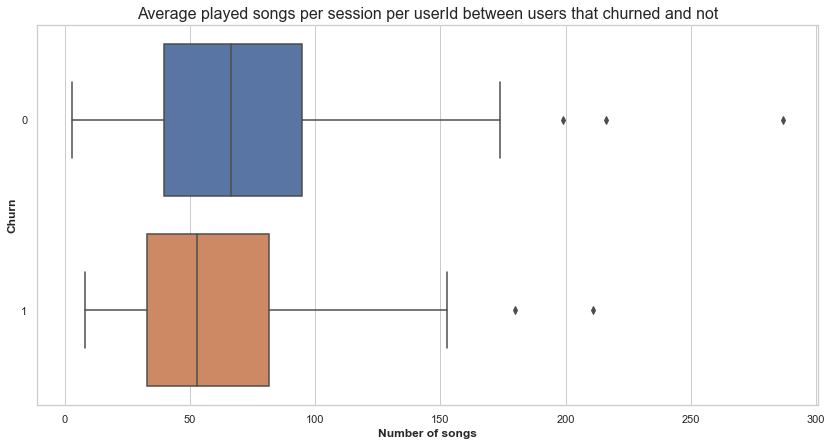

In [344]:
# 2. Average played songs per session
avg_songs_session = sparkify_events.where(sparkify_events.song.isNotNull()).\
                    groupby(['userId', 'churn', 'sessionId']).count().groupby(['userId', 'churn']).\
                    agg({'count': 'avg'}).withColumnRenamed('avg(count)','avg_songs_session').toPandas()

draw_boxplot("Average played songs per session per userId between users that churned and not", "Number of songs",\
             "Churn", "whitegrid", "avg_songs_session", "churn", "h", avg_songs_session)

#### 6. thumbs_down

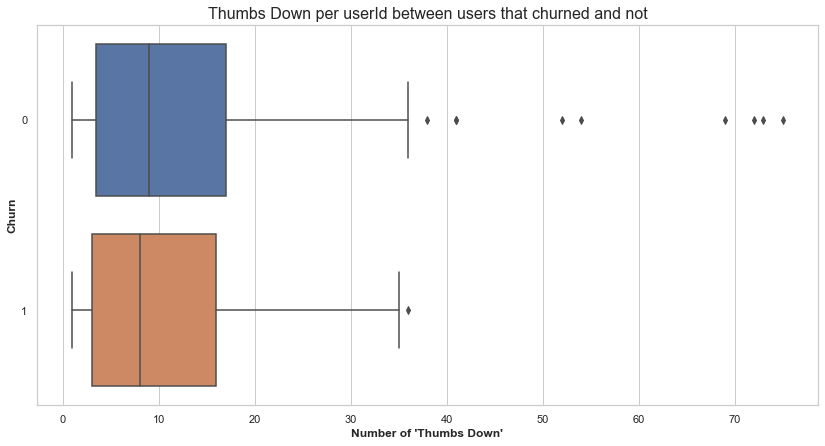

In [345]:
thumbs_down = sparkify_events.filter(sparkify_events['page'] == 'Thumbs Down').groupby("userId", "churn",).count().toPandas()
draw_boxplot("Thumbs Down per userId between users that churned and not", "Number of 'Thumbs Down'",\
             "Churn", "whitegrid", "count", "churn", "h", thumbs_down)

# <a class="anchor" id="Summary">VI. Summary</a>

The project is completely contained in this Notebook and all the steps were executed using the PySpark library for using Spark with Python.

The total amount of features used in the churn prediction model was 15, 5 different Machine Learning models were trained using crossvalidation and for finding the best parameters Grid Search was the chosen option.
A sum up of the results obtained for each model can be seen in the following table:

| Model name | Accuracy | f1score | Training time (min:sec)|
| :-: | :-: | :-: | :-: |
| Random Forest | 0.800000 | 0.736508 | 04:34.036536|
| Logistic Regression | 0.885714 | 0.860829 | 04:08.942884 |
| Decision Tree | 0.800000 | 0.805938 | 04:47.750021 |
| Gradient Boosted Trees | 0.685714 | 0.717108 | 04:24.014526|
| LinearSVC | 0.828571 | 0.750893 | 04:04.784299 |

The model with the best result is Logistic Regresion with an accuracy of 0.885 and a f1 score of 0.861. The features that have more impact are registration_min, errors, friend, played_time_session, avg_songs_session and thumbs_down. From them,  the more negative the value of these features are, most likely the user will stay in the service and will not churn. 

#### Difficulties found
Between the difficulties encountered, using the PySpark library to program the whole project, together with the features definition and join to use them in the models, were the most important ones.

#### Improvements
In order to improve the model in the future it would be good to try with a bigger dataset where the models have more data to learn from and use more parameters in Grid Search to tune the models. These measure would allow to increment the accuracy of the predictions and be more effective therefore in managing the churn problem.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.